In [1920]:
import pandas as pd
import datetime
import os
import csv
import numpy as np

# Constants

In [1921]:
COUNTRY = 'india'

PROJECT_BASE_URL = "/Users/zeko/dev/projects/drishti/machine_learning/scripts/"

DATASET_PATH = PROJECT_BASE_URL + 'data/acled/2019-01-01-2019-05-01-India.csv'
SRC_DIR_NEWS_TEXT_ONLY = PROJECT_BASE_URL + 'data/processed_news_india/'

NEWS_START_DATE = datetime.datetime.strptime("2019-02-24", "%Y-%m-%d").date()
NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_PKL = PROJECT_BASE_URL + 'data/models/india.pkl'
NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_CSV = PROJECT_BASE_URL + 'data/india.csv'

LOCATIONS_OF_INTEREST = PROJECT_BASE_URL + "data/locations/" + "top-15-india-locations.csv"
FASTTEXT_DATASET_DIR = PROJECT_BASE_URL + "data/fasttext_datasets/"

FINAL_DATASET_DATE_LOCATION_HEADER = 'src'

SENTIMENT_FILES_DIR = PROJECT_BASE_URL + 'data/sentiment_news_{}/'.format(COUNTRY)

FINAL_MODEL_PATH = PROJECT_BASE_URL + 'data/models/ensemble/model_{}.pkl'.format(COUNTRY)
FINAL_DATASET_PATH = PROJECT_BASE_URL + 'data/saved_datasets/{}.pkl'.format(COUNTRY)
LIVE_PREDICTIONS_PATH = PROJECT_BASE_URL + 'data/saved_predictions/{}.json'.format(COUNTRY)

LIVE_DATA_FLAG = True

In [1922]:
# builds a set which stores <date__location> of violence
violence_log = set()
LAST_VIOLENCE_DATE = None

# Data

## ACLED

In [1923]:
# Read ACLED data
data = pd.read_csv(DATASET_PATH)

In [1924]:
def build_violence_log_key(log_date, log_location):
    return "{}__{}".format(log_date, log_location)

## Populate the violence_log set

In [1925]:
# populates violence_log
for index, row in data.iterrows():
    if index == 0:
        pass
    else:
        d = datetime.datetime.strptime(row['event_date'], "%d %B %Y")
        event_date = d.strftime('%Y-%m-%d')
        violence_log.add(build_violence_log_key(event_date, row['location']))
        if LAST_VIOLENCE_DATE is None:
            # we just need the first event date as dataset has events ordered latest first
            LAST_VIOLENCE_DATE = d.date()

print("Last Violence Date: {}".format(LAST_VIOLENCE_DATE))
            

Last Violence Date: 2019-04-27


## Get 15 most active cities

In [1926]:
# Get most active cities
locations = []

# read relevant locations
with open(LOCATIONS_OF_INTEREST, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file, fieldnames=['name', 'lat', 'long', 'freq'])

    # each row is an ordered dict
    for row in csv_reader:
        locations.append(row)

## Helper method to get News data for a particular date

In [1927]:
def read_news_text_only(date, location):
    filepath = "{}{}__{}.txt".format(SRC_DIR_NEWS_TEXT_ONLY, date, location)
    if os.path.isfile(filepath):
        with open(filepath, 'r') as text_file:
            return text_file.read()
    else:
        return None

## Helper method to create Final Dataset

In [1928]:
# method for creating dataset for scikit learn methods
def create_dataset(start_date, days, dataset_label, live_data=False):
    
    news_col = []
    labels_col = []
    src = []

    for curr_date in (start_date + datetime.timedelta(days=i) for i in range(days)):
        
        violence_date = curr_date + datetime.timedelta(days=2)
        print("Included news broadcasted on {} for violence on {}".format(curr_date, violence_date))        
        
        for location in locations:
            
            # check if violence occurred
            if build_violence_log_key(violence_date, location['name']) in violence_log:
                label = 'VIOLENCE'
            else:
                label = 'NO_VIOLENCE'
            news = read_news_text_only(curr_date, location['name'])
            if news is not None:
                news_col.append(news)
                labels_col.append(label)
                src.append(build_violence_log_key(violence_date, location['name']))
    
    # Add live values
    if live_data:
        curr_date = datetime.datetime.now().date()
        for location in locations:
            news = read_news_text_only(curr_date, location['name'])
            if news is not None:
                news_col.append(news)
                labels_col.append('NO_VIOLENCE')
                src.append(build_violence_log_key(curr_date, location['name']))
        
        
    return {'news': news_col, 'labels': labels_col, FINAL_DATASET_DATE_LOCATION_HEADER: src}
        

## Create Final dataset

In [1929]:
# count_of_news_days is the number of days we will process for
delta = LAST_VIOLENCE_DATE - NEWS_START_DATE
count_of_news_days = delta.days - 1

# processed_data = create_dataset(NEWS_START_DATE, count_of_news_days, "DS")
processed_data = create_dataset(NEWS_START_DATE, count_of_news_days, "DS", live_data=LIVE_DATA_FLAG)

news_signal_for_violence_ds = pd.DataFrame(processed_data, columns= ['news', 'labels', FINAL_DATASET_DATE_LOCATION_HEADER])


Included news broadcasted on 2019-02-24 for violence on 2019-02-26
Included news broadcasted on 2019-02-25 for violence on 2019-02-27
Included news broadcasted on 2019-02-26 for violence on 2019-02-28
Included news broadcasted on 2019-02-27 for violence on 2019-03-01
Included news broadcasted on 2019-02-28 for violence on 2019-03-02
Included news broadcasted on 2019-03-01 for violence on 2019-03-03
Included news broadcasted on 2019-03-02 for violence on 2019-03-04
Included news broadcasted on 2019-03-03 for violence on 2019-03-05
Included news broadcasted on 2019-03-04 for violence on 2019-03-06
Included news broadcasted on 2019-03-05 for violence on 2019-03-07
Included news broadcasted on 2019-03-06 for violence on 2019-03-08
Included news broadcasted on 2019-03-07 for violence on 2019-03-09
Included news broadcasted on 2019-03-08 for violence on 2019-03-10
Included news broadcasted on 2019-03-09 for violence on 2019-03-11
Included news broadcasted on 2019-03-10 for violence on 2019-0

## Persist dataset to disk 

In [1930]:
# persists final dataset as Pickle file
news_signal_for_violence_ds.to_pickle(NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_PKL)

# persists final dataset as CSV
news_signal_for_violence_ds.to_csv(NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_CSV, sep=',', encoding='utf-8')


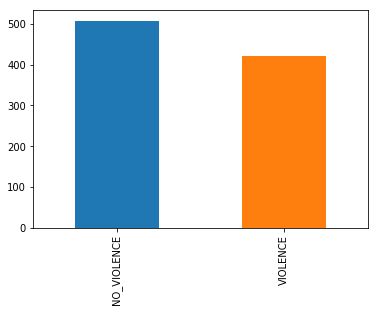

In [1931]:
# Check label frequency in final dataset
news_signal_for_violence_ds.labels.value_counts().plot(kind='bar');

## Read final dataset from disk

In [1932]:
news_signal_for_violence_ds = pd.read_pickle(NEWS_SIGNAL_FOR_VIOLENCE_DATASET_FILE_PKL)
news_signal_for_violence_ds

,news,labels,src
0,deputy sp killed in encounter in jammu and kas...,VIOLENCE,2019-02-26__Jammu
1,senior police officer indian army jawan killed...,NO_VIOLENCE,2019-02-26__Srinagar
2,toxic moonshine kills 133 people and leaves hu...,VIOLENCE,2019-02-26__Delhi-New Delhi
3,ludhiana land scam ask minister ashu to resign...,VIOLENCE,2019-02-26__Ludhiana
4,rajamaharaja government in punjab #39;mahagath...,NO_VIOLENCE,2019-02-26__Bathinda
5,assam hooch tragedy toll rises to 124\ndhaka p...,VIOLENCE,2019-02-26__Guwahati
6,,VIOLENCE,2019-02-26__Imphal
7,ysrcp chief jagan in london to bring hawala mo...,VIOLENCE,2019-02-26__Hyderabad
8,cheque bounce cases five days later farmers li...,NO_VIOLENCE,2019-02-26__Patiala
9,india vs pakistan sourav ganguly clarifies sta...,NO_VIOLENCE,2019-02-26__Kolkata


## Cleaning the final dataset

In [1933]:
news_signal_for_violence_ds.describe()

,news,labels,src
count,930,930,930
unique,906,2,930
top,,NO_VIOLENCE,2019-03-14__Patiala
freq,25,508,1


In [1934]:
# Removing null or empty values
news_signal_for_violence_ds.dropna(axis = 0, how ='any') 
news_signal_for_violence_ds['news'].replace('', np.nan, inplace=True)
news_signal_for_violence_ds.dropna(axis=0, how='any', inplace=True)

# shuffle
if not LIVE_DATA_FLAG:
    news_signal_for_violence_ds = news_signal_for_violence_ds.sample(frac=1).reset_index(drop=True)

# Renaming 'label' attrivute to 'violence_label'
news_signal_for_violence_ds = news_signal_for_violence_ds.rename(columns = {'labels': 'violence_label'})

# make copy of dataset
ds2 = news_signal_for_violence_ds.copy(deep=True)

# drop date_location attribute
news_signal_for_violence_ds.drop([FINAL_DATASET_DATE_LOCATION_HEADER], inplace=True, axis=1)

In [1935]:
news_signal_for_violence_ds.describe()

,news,violence_label
count,905,905
unique,905,2
top,regrettable that nonneutral person appointed o...,NO_VIOLENCE
freq,1,493


## Splitting data into Training and Test set

In [1936]:
# y are the labels
y = news_signal_for_violence_ds.violence_label

# dropping the 'src' attribute as it is not required
news_signal_for_violence_ds.drop(['violence_label'], axis=1, inplace=True)

# X is the news data
X = news_signal_for_violence_ds.news

from sklearn.model_selection import train_test_split

frac = 0.2
rowCount = len(X.index)
if (0.2*rowCount <= len(locations)):
    frac = 15.0/rowCount
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=frac, shuffle = False)

In [1937]:
print(frac)

0.2


## Helper methods to create dataset for FastTest


In [1938]:

# method for creating fasttext sets
def create_fasttext_set(records, labels, set_tag):

    OUTPUT_DIR = FASTTEXT_DATASET_DIR
    out_file_path = "{}{}.txt".format(OUTPUT_DIR, set_tag)
    
    records = records.tolist()
    labels = labels.tolist()
    
    no_of_records = len(records)
    
    combined = ""
    for i in range(no_of_records):
        record_data = records[i]
        record_label = 0 if labels[i] == "NO_VIOLENCE" else 1
        combined += "__label__{} {}{}".format(record_label, record_data, os.linesep)
        
    with open(out_file_path, 'w') as out_file:
        out_file.write(combined)
    

def create_fasttext_train_and_test_sets(X_train, X_test, y_train, y_test):
    
    create_fasttext_set(X_train, y_train, "train_set")
    create_fasttext_set(X_test, y_test, "test_set")


In [1939]:
# Writes generated datasets to disk
create_fasttext_train_and_test_sets(X_train, X_test, y_train, y_test)

# Building the Model

In [1940]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Multinomial Naive Bayes

In [1941]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print("Multinomial Naive Bayes")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Multinomial Naive Bayes
accuracy 0.6077348066298343
              precision    recall  f1-score   support

 NO_VIOLENCE       0.60      0.92      0.73       102
    VIOLENCE       0.67      0.20      0.31        79

   micro avg       0.61      0.61      0.61       181
   macro avg       0.63      0.56      0.52       181
weighted avg       0.63      0.61      0.54       181



In [1942]:
# vectorizer = CountVectorizer()
# # tokenize and build vocab
# vectorizer.fit(X_train)
# # summarize
# print(vectorizer.vocabulary_)
# # encode document
# vector = vectorizer.transform(X_train)
# # summarize encoded vector
# print(vector.shape)
# print(type(vector))
# print(vector.toarray())

## SGD Classfier

In [1943]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print("SGD Classifier")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

SGD Classifier
accuracy 0.5524861878453039
              precision    recall  f1-score   support

 NO_VIOLENCE       0.57      0.81      0.67       102
    VIOLENCE       0.47      0.22      0.30        79

   micro avg       0.55      0.55      0.55       181
   macro avg       0.52      0.51      0.48       181
weighted avg       0.53      0.55      0.51       181



## Logistic Regression

In [1944]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print("Logistic Regression")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Logistic Regression
accuracy 0.5193370165745856
              precision    recall  f1-score   support

 NO_VIOLENCE       0.56      0.74      0.63       102
    VIOLENCE       0.41      0.24      0.30        79

   micro avg       0.52      0.52      0.52       181
   macro avg       0.48      0.49      0.47       181
weighted avg       0.49      0.52      0.49       181



/Users/zeko/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Including Sentiment Analysis in the models

In [1945]:
import json
import os
from sklearn.base import BaseEstimator, TransformerMixin

### Sentiment Score helper methods

In [1946]:
def build_sentiment_file_path(date_location):
    return SENTIMENT_FILES_DIR + '{}.txt'.format(date_location)

def get_sentiment_file(date_location):
    file_path = build_sentiment_file_path(date_location)
    
    # check if sentiment file exists
    if os.path.isfile(file_path):
        with open(file_path) as f:
            data = json.load(f)
            return data
    else:
        return None

def compute_avg_score(sentiment_file):        
    s = 0.0
    ct = 0
    for i in sentiment_file:
        if i is not None:
            s += i['score'] * i['magnitude'] * 100
            ct += 1
    if ct is not 0:
        return s / ct
    else:
        return 0
    
def get_sentiment_score(date_location):
    """Helper code to get sentiment for a day"""
    sentiment_file = get_sentiment_file(date_location)

    if sentiment_file is None:
        print("Sentiment not available for {}".format(date_location))
        return 0

    score = compute_avg_score(sentiment_file)
#     print("Sentiment for {}: {}".format(date_location, score))
    return score

In [1947]:
ds2.describe()

,news,violence_label,src
count,905,905,905
unique,905,2,905
top,regrettable that nonneutral person appointed o...,NO_VIOLENCE,2019-03-14__Patiala
freq,1,493,1


In [1948]:
sentiment_scores = []
for i in ds2['src']:
#     sentiment_scores.append(int(get_sentiment_score(i) * 1000))
    sentiment_scores.append(get_sentiment_score(i))

ds3 = ds2.copy(deep=True)
ds3['sentiment_score'] = sentiment_scores


In [1949]:
ds2.describe()

,news,violence_label,src
count,905,905,905
unique,905,2,905
top,regrettable that nonneutral person appointed o...,NO_VIOLENCE,2019-03-14__Patiala
freq,1,493,1


In [1950]:
ds3.describe(include='all')

,news,violence_label,src,sentiment_score
count,905,905,905,905.000000
unique,905,2,905,NaN
top,regrettable that nonneutral person appointed o...,NO_VIOLENCE,2019-03-14__Patiala,NaN
freq,1,493,1,NaN
mean,NaN,NaN,NaN,0.577265
std,NaN,NaN,NaN,8.767309
min,NaN,NaN,NaN,-64.000002
25%,NaN,NaN,NaN,-3.666667
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,3.916667


In [1951]:
# persists final dataset as Pickle file
ds3.to_pickle(FINAL_DATASET_PATH)

ds4 = ds3.copy(deep=True)

In [1954]:
# ds4.drop(['src', 'news'], axis=1, inplace=True)
print(ds4.describe(include='all'))
ds4.to_csv(FINAL_DATASET_PATH + '_analytics.csv', sep=',', encoding='utf-8')

       violence_label  sentiment_score
count             905       905.000000
unique              2              NaN
top       NO_VIOLENCE              NaN
freq              493              NaN
mean              NaN         0.577265
std               NaN         8.767309
min               NaN       -64.000002
25%               NaN        -3.666667
50%               NaN         0.000000
75%               NaN         3.916667
max               NaN        64.666665


## Final Dataframe

In [1877]:
from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction.text import TfidfVectorizer

# y are the labels
y = ds3.violence_label
s = ds3.src

mapper = DataFrameMapper([
     ('news', TfidfVectorizer()),
     ('sentiment_score', None)
 ])

In [1878]:
X = mapper.fit_transform(ds3)

### Split into training and test sets

In [1879]:
from sklearn.model_selection import train_test_split

# frac = 0.2
# rowCount = len(X.index)
# if (0.2*rowCount <= len(locations)):
#     frac = 15.0/rowCount

# frac is calculated above
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=frac, shuffle = False)

### RandomForest Classifier

In [1880]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc.fit(X_train, y_train)
 
predicted = rfc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, predicted))

accuracy 0.5193370165745856
              precision    recall  f1-score   support

 NO_VIOLENCE       0.60      0.91      0.72       102
    VIOLENCE       0.65      0.22      0.32        79

   micro avg       0.61      0.61      0.61       181
   macro avg       0.63      0.56      0.52       181
weighted avg       0.62      0.61      0.55       181



### SGD Classifier

In [1881]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print("SGD Classifier")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

SGD Classifier
accuracy 0.569060773480663
              precision    recall  f1-score   support

 NO_VIOLENCE       0.61      0.65      0.63       102
    VIOLENCE       0.51      0.47      0.49        79

   micro avg       0.57      0.57      0.57       181
   macro avg       0.56      0.56      0.56       181
weighted avg       0.57      0.57      0.57       181



### Logistic Regression

In [1882]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print("Logistic Regression")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Logistic Regression
accuracy 0.5303867403314917
              precision    recall  f1-score   support

 NO_VIOLENCE       0.56      0.75      0.64       102
    VIOLENCE       0.43      0.24      0.31        79

   micro avg       0.53      0.53      0.53       181
   macro avg       0.50      0.50      0.48       181
weighted avg       0.51      0.53      0.50       181



/Users/zeko/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Gaussian Naive bayes

In [1883]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

print("Gaussian NB")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Gaussian NB
accuracy 0.46408839779005523
              precision    recall  f1-score   support

 NO_VIOLENCE       0.52      0.52      0.52       102
    VIOLENCE       0.39      0.39      0.39        79

   micro avg       0.46      0.46      0.46       181
   macro avg       0.46      0.46      0.46       181
weighted avg       0.46      0.46      0.46       181



### KNeighbors Classifier

In [1884]:
from sklearn.neighbors import KNeighborsClassifier
kneigh = KNeighborsClassifier(n_neighbors=3)
kneigh.fit(X_train, y_train) 

y_pred = kneigh.predict(X_test)

print("KNeighborsClassifier")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

KNeighborsClassifier
accuracy 0.5082872928176796
              precision    recall  f1-score   support

 NO_VIOLENCE       0.58      0.45      0.51       102
    VIOLENCE       0.45      0.58      0.51        79

   micro avg       0.51      0.51      0.51       181
   macro avg       0.52      0.52      0.51       181
weighted avg       0.52      0.51      0.51       181



# Voting Classifier - Ensemble of all the previous models
### 'Wisdom of the Crowd'

In [1885]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('rfc', rfc), ('logreg', logreg), 
                                  ('gnb', gnb), ('kneigh', kneigh), 
                                  ('sgd', sgd)], voting='hard')
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

print("Voting Classifier")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/Users/zeko/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Voting Classifier
accuracy 0.5469613259668509
              precision    recall  f1-score   support

 NO_VIOLENCE       0.57      0.76      0.66       102
    VIOLENCE       0.47      0.27      0.34        79

   micro avg       0.55      0.55      0.55       181
   macro avg       0.52      0.52      0.50       181
weighted avg       0.53      0.55      0.52       181



In [1897]:
y_pred

array(['NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'VIOLENCE', 'VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'NO_VIOLENCE', 'NO_VIOLENCE', 'VIOLENCE', 'NO_VIOLENCE',
       'NO_VIOLENCE', 'VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'VIOLENCE',
       'VIOLENCE', 'VIOLENCE', 'VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'VIOLENCE',
       'NO_VIOLENCE', 'VIOLENCE', 'NO_VIOLENCE', 'VIOLENCE',
       'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'VIOLENCE',
       'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE', 'NO_VIOLENCE',
       'NO_VIOLENCE', 'NO

## Store ensemble model on disk

In [1886]:
import pickle

with open(FINAL_MODEL_PATH, 'wb') as f:  
    pickle.dump(vc, f)

In [1899]:
res = pd.concat([s, pd.Series(y_pred)], axis=1)
print(res.describe())

                        src            0
count                   905          181
unique                  905            2
top     2019-03-14__Patiala  NO_VIOLENCE
freq                      1          136


## Store live predictions on disk

In [1906]:
def get_location_object(loc_name):
    for i in locations:
        if i['name'] == loc_name:
            return i

In [1916]:
src_list = s.tolist()[-1*len(pred_list):]
pred_list = y_pred.tolist()

live_date = datetime.datetime.now().date()

result = []

print('src list length: {}'.format(len(src_list)))
print('pred list length: {}'.format(len(pred_list)))
print()

for i, entry in enumerate(src_list):
    if entry.startswith('{}'.format(live_date)):
        x = entry.split('__')
        loc_obj = get_location_object(x[1])
        result.append({
            'location': {
                'name': loc_obj['name'],
                'lat': loc_obj['lat'],
                'long': loc_obj['long'],
            },
            'prediction': pred_list[i]
        })


with open(LIVE_PREDICTIONS_PATH, 'w') as f:  
    json.dump(result, f)

src list length: 181
pred list length: 181

